# **Import Module**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import kagglehub

from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# **Download Dataset**

In [2]:
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/stroke-prediction-dataset


# **Load Dataset**

In [3]:
df = pd.read_csv(path+"/healthcare-dataset-stroke-data.csv")

In [4]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# **Exploratory Data Analysis**

In [6]:
df_eda = df.copy()

df_eda['gender'] = df_eda['gender'].apply(lambda x: 0 if x == 'Male' else 1 if x == "Female" else 2)
df_eda['ever_married'] = df_eda['ever_married'].apply(lambda x: 0 if x == 'Yes' else 1)
df_eda['Residence_type'] = df_eda['Residence_type'].apply(lambda x: 0 if x == 'Urban' else 1)

smoke_mapping = {
    'never smoked': 0,
    'formerly smoked': 1,
    'smokes': 2,
    'Unknown': 3
}

df_eda['smoking_status'] = df_eda['smoking_status'].map(smoke_mapping)
df_eda = pd.get_dummies(df_eda, columns=['work_type'], drop_first=True, prefix='work_type', dtype=int)

df_eda.drop(columns=['id'], axis=1, inplace=True)

## **Correlation**

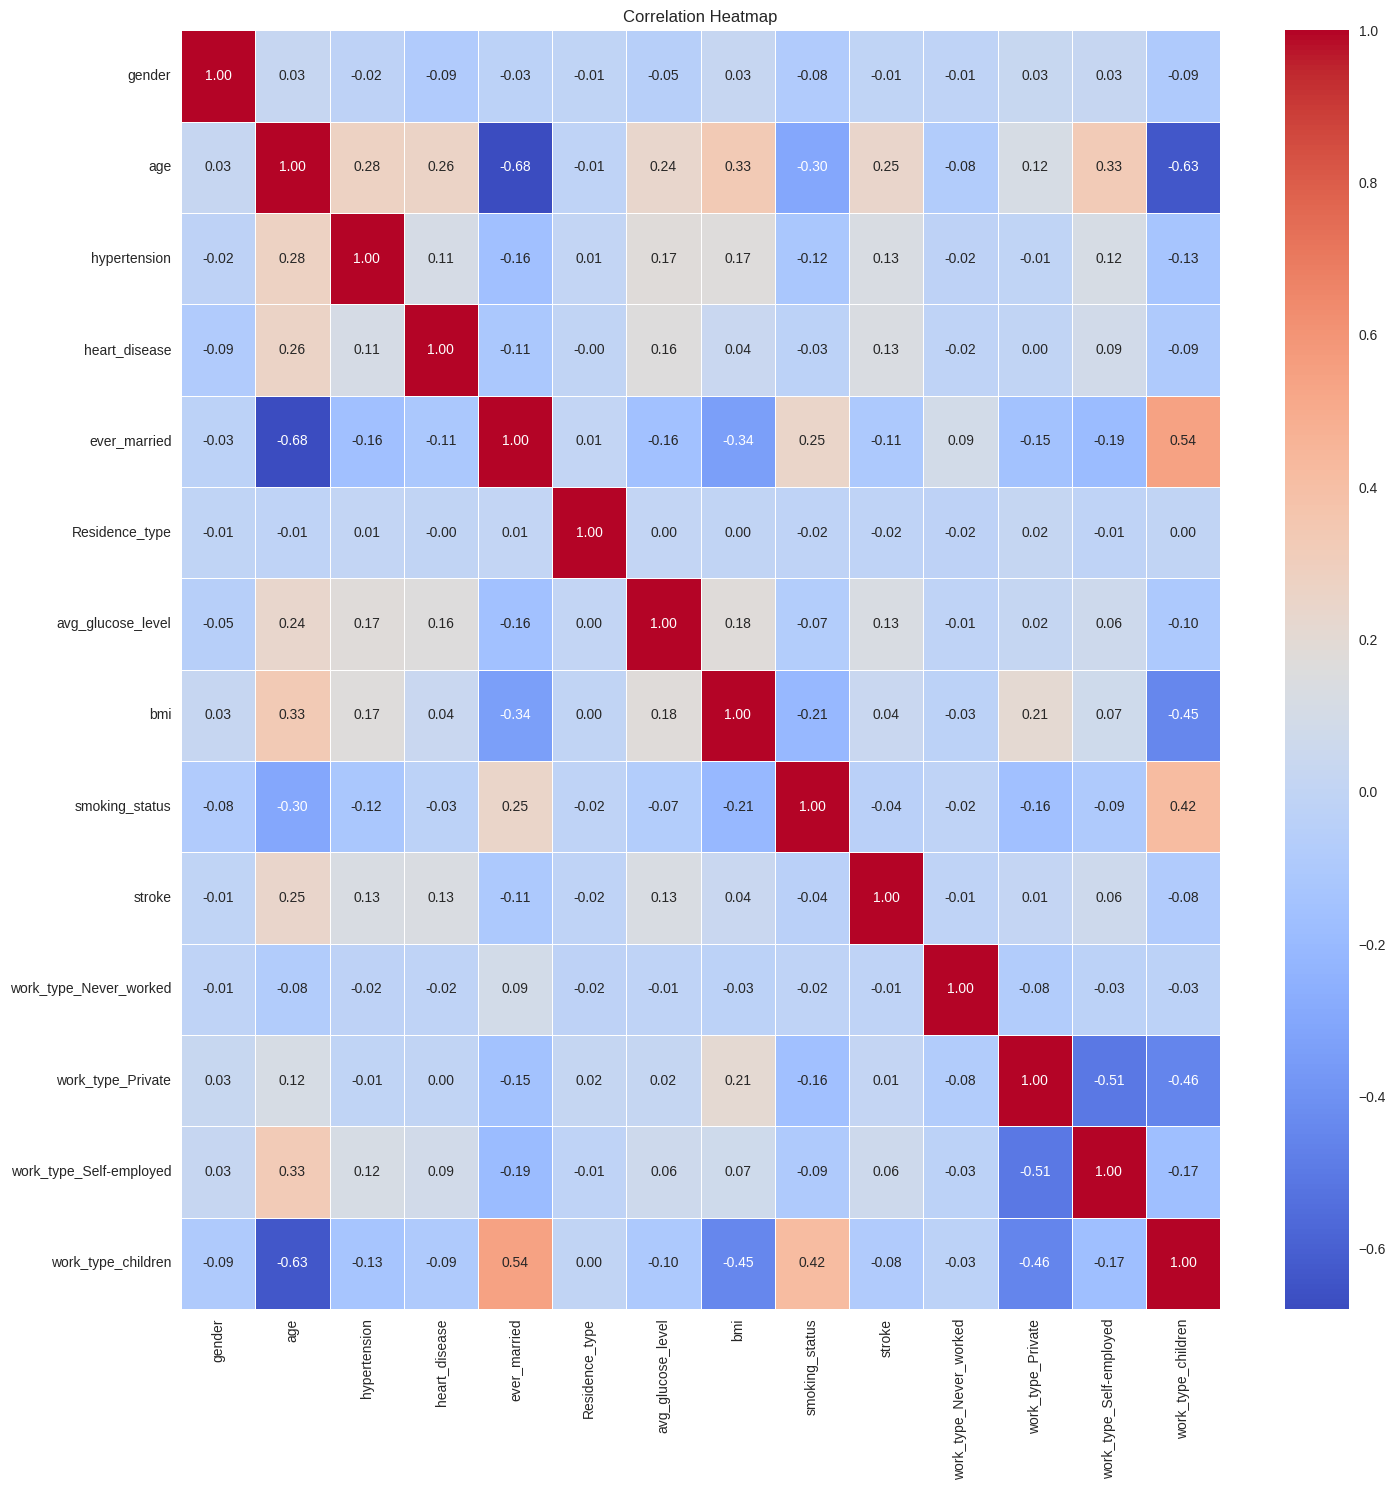

In [17]:
data_corr = df_eda.corr()

plt.figure(figsize=(15, 15))

sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

## **Interpretasi**
Berdasarkan heatmap korelasi, terlihat bahwa usia (age) memiliki korelasi positif tertinggi dengan stroke (0.25), diikuti oleh hipertensi (0.13) dan penyakit jantung (0.13), menunjukkan bahwa ketiga faktor ini berpotensi meningkatkan risiko stroke. Selain itu, ever_married (-0.11) dan work_type_children (0.54) memiliki korelasi signifikan dengan variabel lain, seperti usia, yang mengindikasikan bahwa status pernikahan dan pekerjaan mungkin memengaruhi profil risiko. Namun, Residence_type hampir tidak berkorelasi dengan variabel lain (nilai mendekati 0), sehingga kurang relevan sebagai prediktor. Korelasi negatif antara BMI (-0.45) dan work_type_children mencerminkan bahwa anak-anak cenderung memiliki BMI lebih rendah. Data juga menunjukkan multikolinearitas antara beberapa variabel, seperti usia dan work_type_children (0.63), yang perlu dipertimbangkan dalam pemodelan untuk menghindari bias. Secara keseluruhan, usia, kondisi medis (hipertensi, penyakit jantung), dan faktor gaya hidup (status merokok, BMI) adalah prediktor kunci yang memerlukan analisis lebih mendalam.



## **Data Distribution**

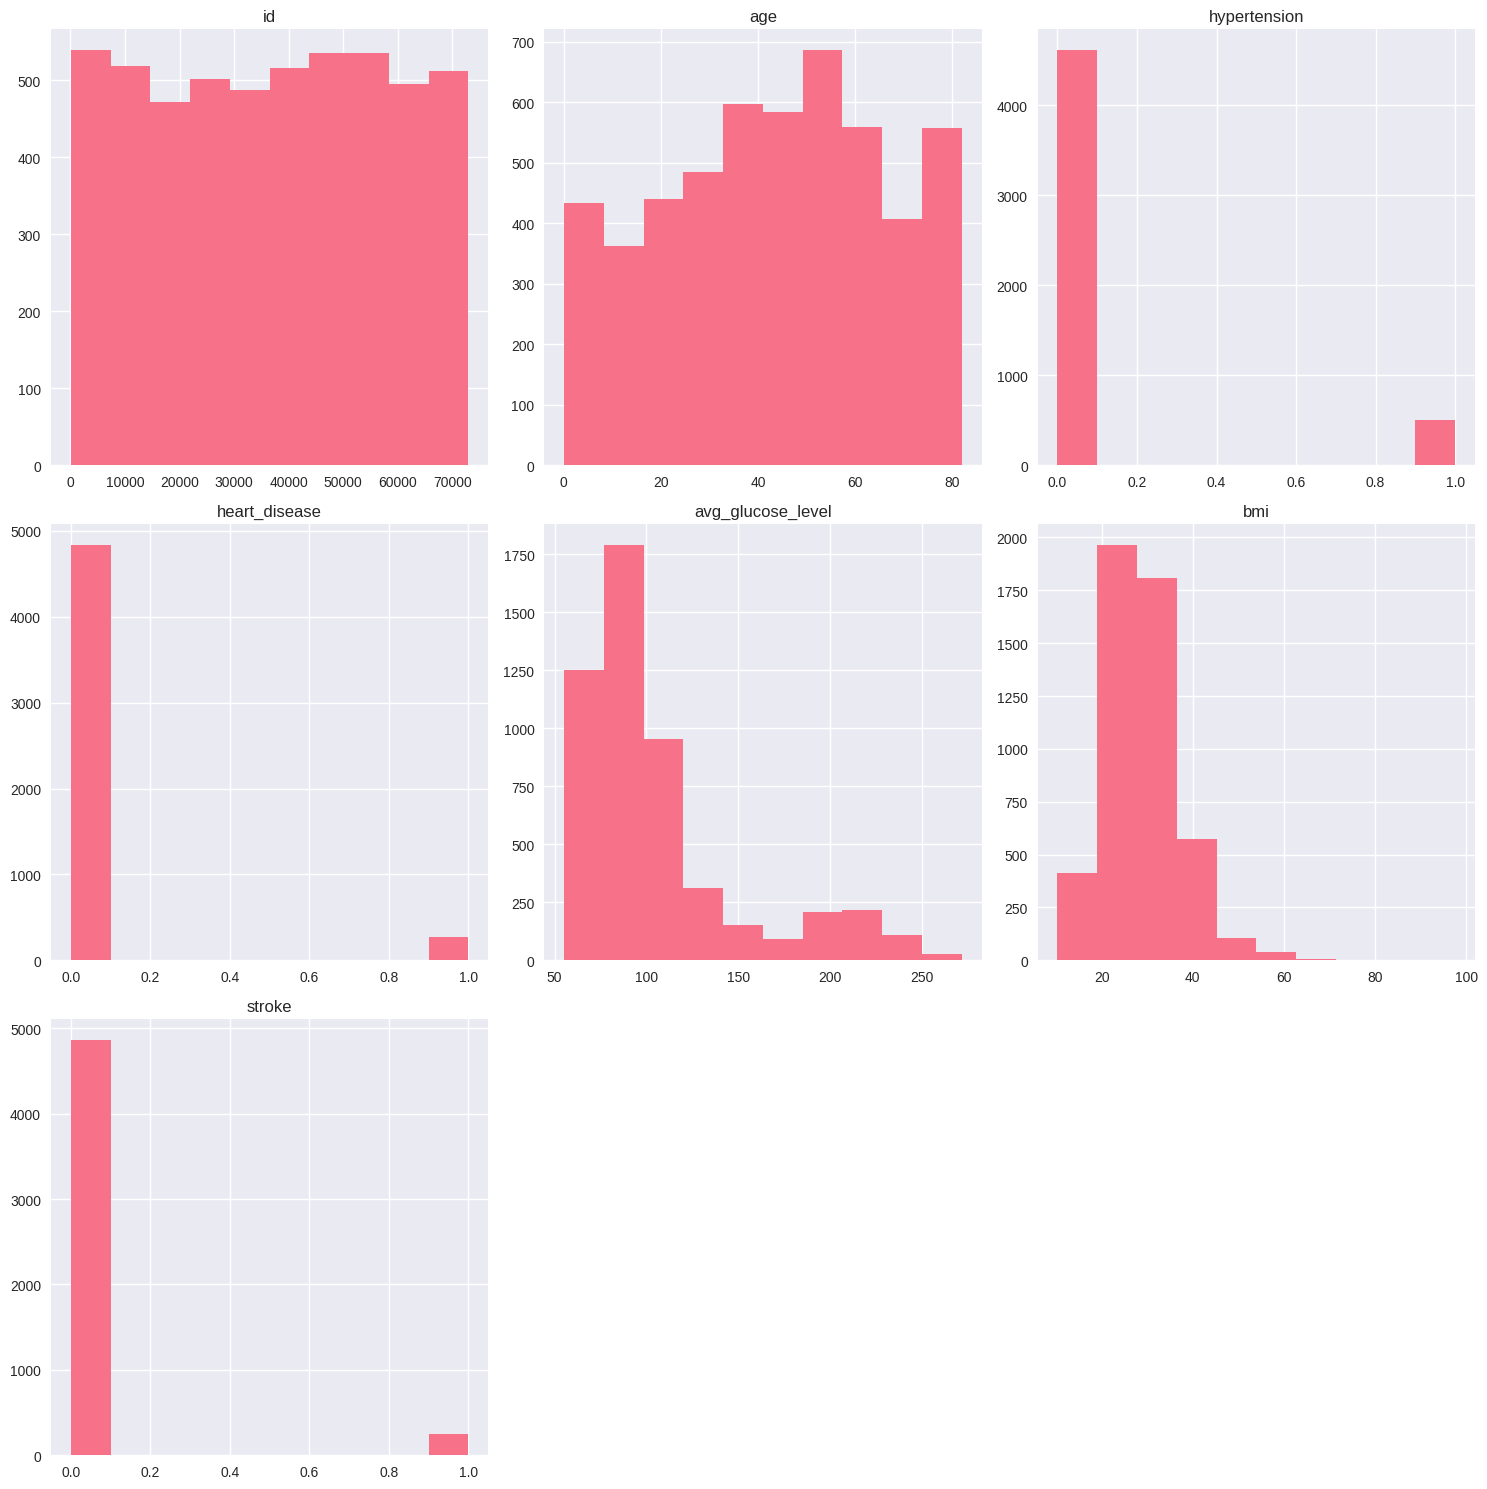

In [16]:
df.hist(figsize=(15, 15))
plt.tight_layout()
plt.show()

## **Interpretasi**
Berdasarkan hasil eksplorasi data numerik, sebagian besar fitur memiliki distribusi yang tidak seimbang. Fitur age terdistribusi relatif normal dengan mayoritas di usia 40–60 tahun, namun terdapat nilai ekstrem seperti 0.08 yang perlu diverifikasi. Fitur avg_glucose_level dan bmi menunjukkan distribusi miring ke kanan (right-skewed) dengan beberapa outlier ekstrem, sehingga transformasi log atau scaling dapat dipertimbangkan. Rata-rata BMI (28.89) menunjukkan populasi cenderung overweight, dan terdapat 201 nilai kosong pada fitur ini yang perlu ditangani. Fitur biner seperti hypertension dan heart_disease didominasi oleh nilai nol (tidak memiliki kondisi tersebut), sementara label target stroke juga sangat tidak seimbang (hanya sekitar 4.9% kasus positif), sehingga perlu penanganan class imbalance saat membangun model prediksi.



## **Outliers Detection**

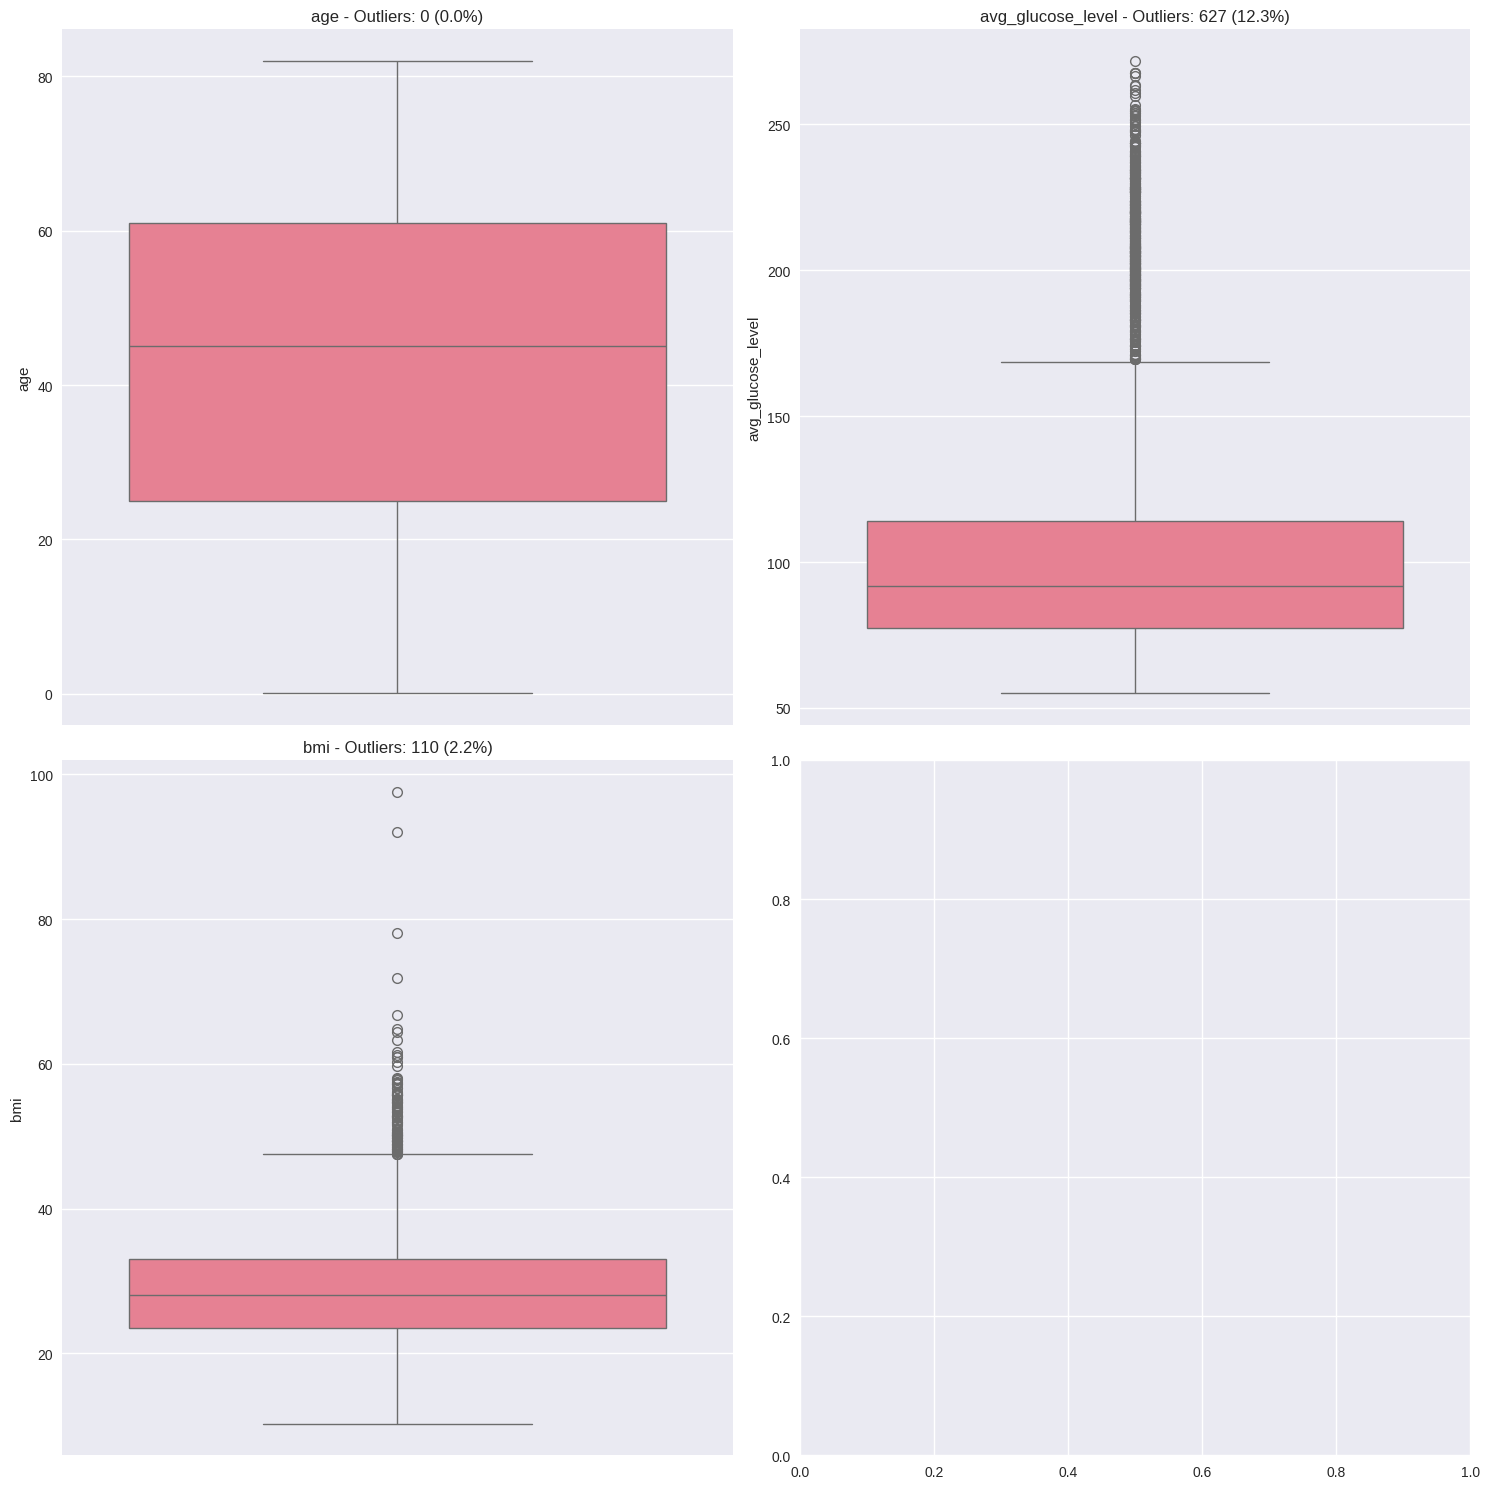

In [15]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['id', 'hypertension', 'heart_disease', 'stroke']] # Tidak mengambil yang kategorikal

outlier_summary = []

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for i, col in enumerate(numerical_cols[:4]):
    if i < len(axes):

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100

        outlier_summary.append({
                'Column': col,
                'Outlier_Count': outlier_count,
                'Outlier_Percentage': f"{outlier_percentage:.2f}%",
                'Lower_Bound': f"{lower_bound:.2f}",
                'Upper_Bound': f"{upper_bound:.2f}"
            })

        sns.boxplot(data=df, y=col, ax=axes[i])
        axes[i].set_title(f'{col} - Outliers: {outlier_count} ({outlier_percentage:.1f}%)')

plt.tight_layout()
plt.show()

## **Interpretasi**
Fitur age tidak memiliki outlier, namun tetap mengandung nilai sangat rendah mendekati nol yang perlu divalidasi kebenarannya. Fitur avg_glucose_level mengandung outlier cukup banyak yaitu 627 data (12.3%), dengan nilai yang jauh lebih tinggi dari rentang interkuartil, menunjukkan distribusi yang sangat skewed. Fitur bmi juga memiliki 110 outlier (2.2%), meskipun skalanya tidak se-ekstrem avg_glucose_level. Keberadaan outlier pada kedua fitur ini dapat mempengaruhi kinerja model prediktif, sehingga perlu dipertimbangkan apakah akan ditangani melalui metode winsorizing, transformasi log, atau penghapusan langsung. Sementara itu, plot terakhir kosong karena tidak ada fitur numerik keempat yang ditampilkan. Secara keseluruhan, penanganan outlier menjadi salah satu langkah penting dalam preprocessing data ini.



## **Target Column Class Distribution**

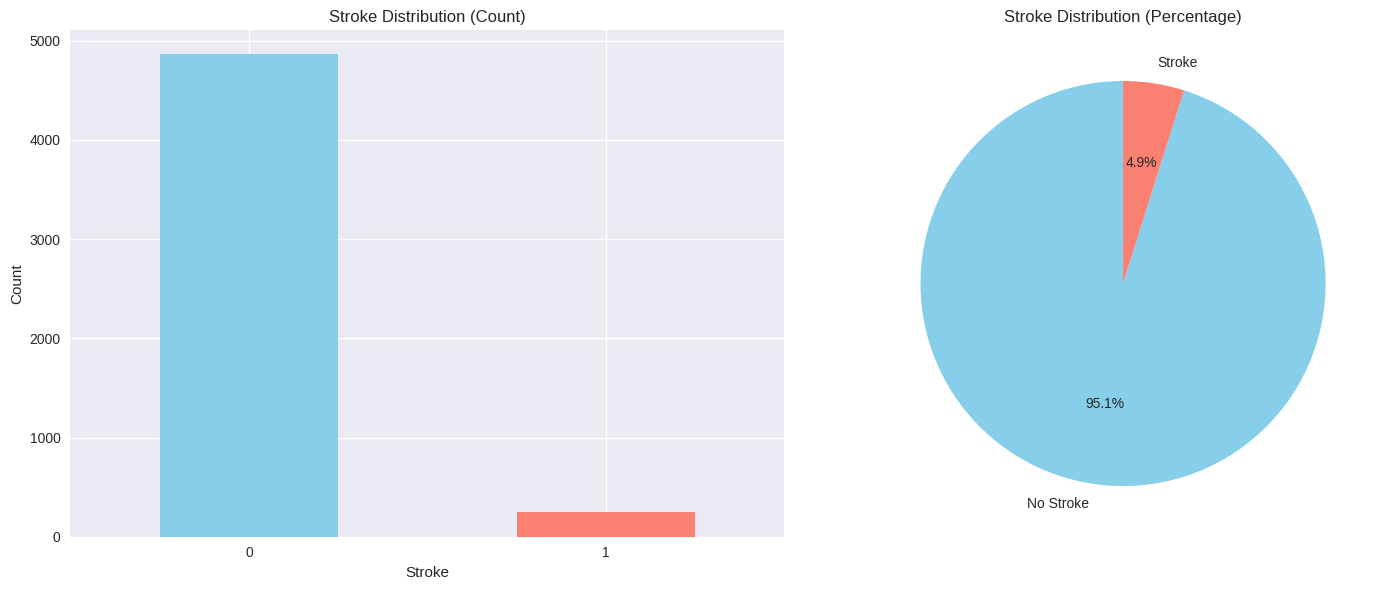

In [10]:
target_counts = df['stroke'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

target_counts.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Stroke Distribution (Count)')
axes[0].set_xlabel('Stroke')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

axes[1].pie(target_counts.values, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%',
                colors=['skyblue', 'salmon'], startangle=90)
axes[1].set_title('Stroke Distribution (Percentage)')

plt.tight_layout()
plt.show()

## **Interpretasi**
Sebagian besar data (sekitar 95.1%) berasal dari individu yang tidak mengalami stroke, sementara hanya 4.9% data berasal dari individu yang mengalami stroke. Ketidakseimbangan ini menunjukkan bahwa dataset bersifat imbalanced, yang dapat menyebabkan model machine learning cenderung bias terhadap kelas mayoritas. Oleh karena itu, perlu dipertimbangkan penanganan khusus seperti resampling (oversampling kelas minoritas atau undersampling kelas mayoritas), penggunaan algoritma yang robust terhadap ketidakseimbangan kelas, atau penerapan class weight adjustment untuk menghasilkan model yang lebih adil dan akurat dalam mendeteksi kasus stroke.



## **Plot Categorical Variables vs Target Variable**

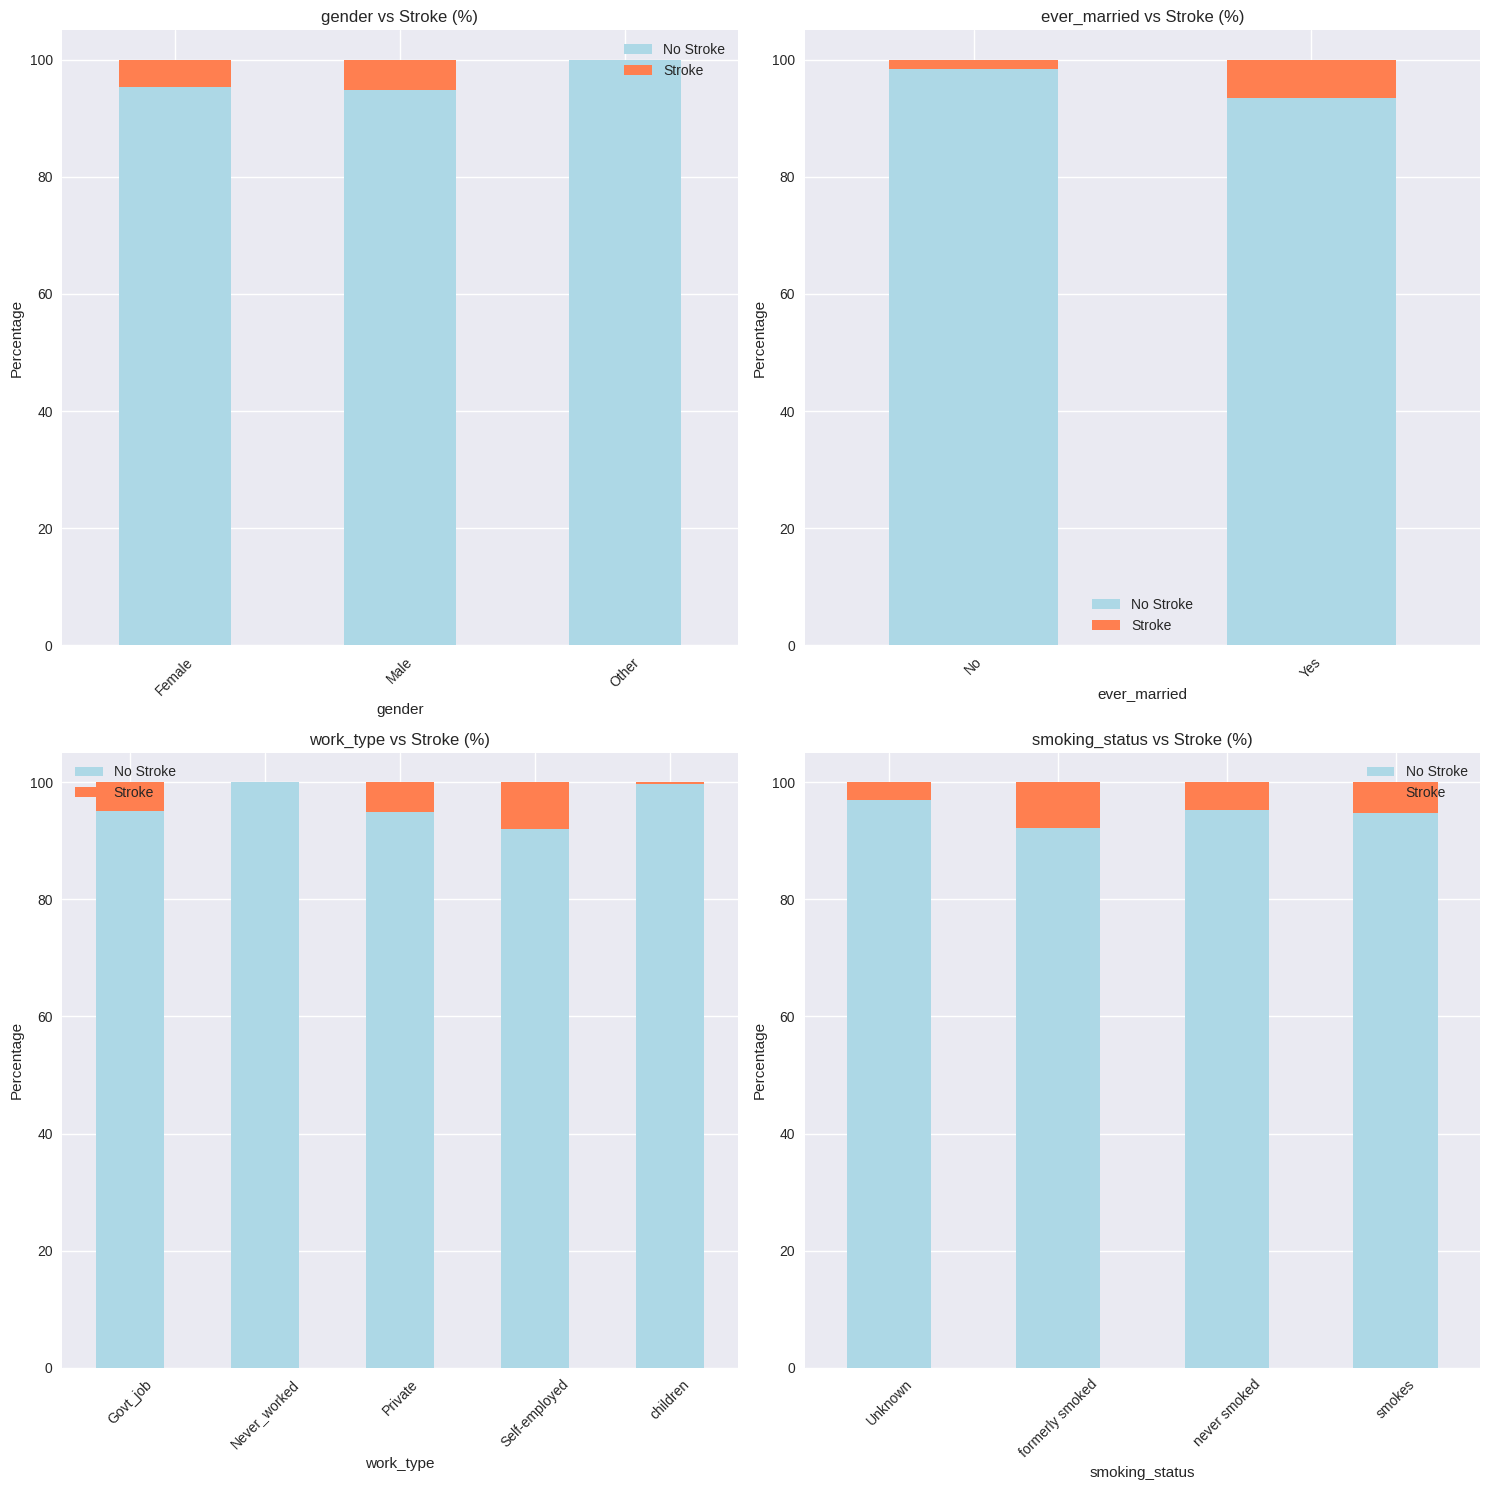

In [14]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if 'id' not in col.lower()]

n_cols = len(categorical_cols)
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(categorical_cols[:4]):
    if i < len(axes):
       ct = pd.crosstab(df[col], df["stroke"], normalize='index') * 100
       ct.plot(kind='bar', ax=axes[i], stacked=True, color=['lightblue', 'coral'])
       axes[i].set_title(f'{col} vs Stroke (%)')
       axes[i].set_xlabel(col)
       axes[i].set_ylabel('Percentage')
       axes[i].legend(['No Stroke', 'Stroke'])
       axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## **Interpretasi**
Terlihat bahwa proporsi penderita stroke sedikit lebih tinggi pada individu yang pernah menikah dibandingkan yang belum menikah. Pada variabel jenis kelamin, baik pria maupun wanita memiliki proporsi stroke yang hampir serupa, sementara kategori "Other" terlalu sedikit untuk dianalisis secara representatif. Terkait jenis pekerjaan, kelompok self-employed dan private menunjukkan persentase stroke yang lebih tinggi dibanding kelompok lain. Pada fitur smoking status, individu yang merokok atau pernah merokok memiliki persentase stroke yang lebih tinggi dibandingkan yang tidak merokok atau status merokoknya tidak diketahui. Temuan ini menunjukkan adanya perbedaan risiko stroke berdasarkan faktor gaya hidup dan status sosial-demografis tertentu, yang penting untuk diperhatikan dalam analisis prediktif lebih lanjut.



## **Pairplot Numeric Feature**

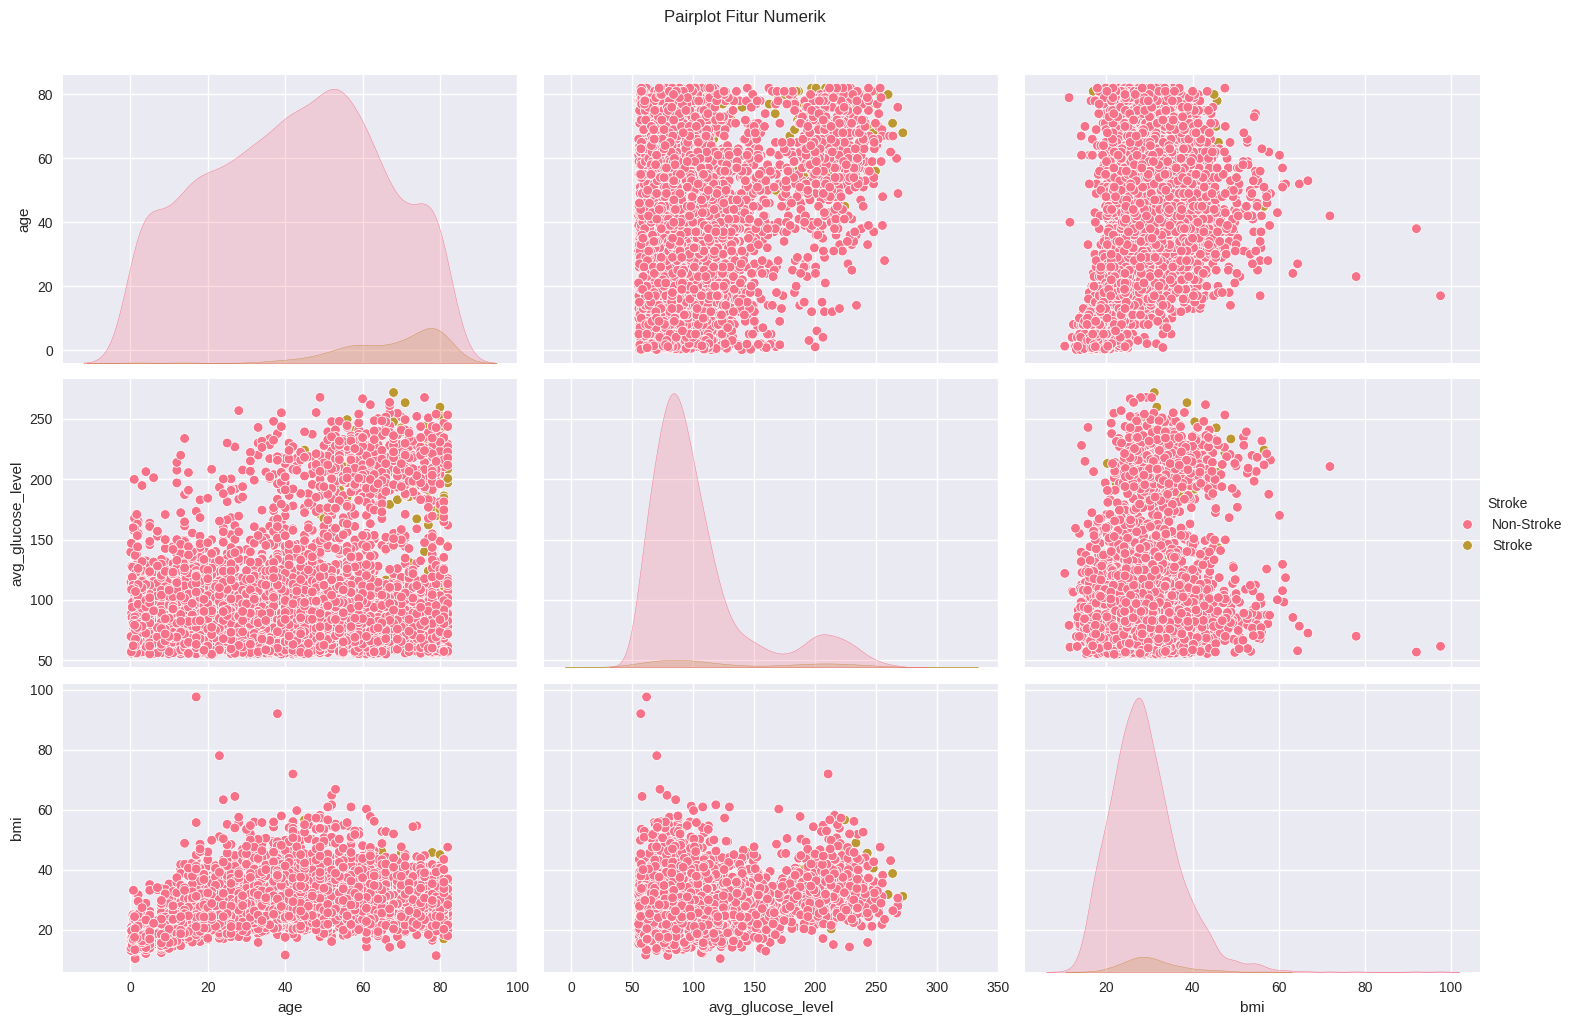

In [21]:
selected_cols = ['age', 'avg_glucose_level', 'bmi', 'stroke']

g = sns.pairplot(df[selected_cols], hue='stroke', diag_kind='kde')

g.fig.set_size_inches(15, 10)
g.fig.suptitle("Pairplot Fitur Numerik", y=1.02)

g._legend.set_title("Stroke")
for t, l in zip(g._legend.texts, ['Non-Stroke', 'Stroke']):
    t.set_text(l)

for text in g._legend.texts:
    text.set_fontsize(10)

g._legend.set_bbox_to_anchor((1.05, 0.5))

plt.tight_layout()
plt.show()

## **Interpretasi**
- Usia (age): Hampir semua kasus stroke terjadi pada individu berusia di atas 50 tahun, dengan konsentrasi tertinggi antara 60–80 tahun. Hal ini menunjukkan bahwa risiko stroke meningkat signifikan seiring bertambahnya usia.

- Tingkat Glukosa Rata-rata (avg_glucose_level): Penderita stroke cenderung memiliki kadar glukosa darah yang lebih tinggi, sebagian besar di atas 150. Ini mendukung hipotesis bahwa kadar gula darah tinggi (misalnya akibat diabetes) merupakan faktor risiko stroke.

- BMI (bmi): Tidak terlihat pola yang sangat jelas antara BMI dan stroke, namun sebagian besar penderita stroke berada dalam rentang BMI 25–40, yang termasuk kategori overweight hingga obesitas. Hal ini menunjukkan bahwa kelebihan berat badan bisa menjadi salah satu faktor pendukung, meskipun tidak sekuat usia dan kadar glukosa.

